<img src="https://swan.web.cern.ch/sites/swan.web.cern.ch/files/pictures/logo_swan_letters.png" alt="SWAN" style="float: left; width: 20%; margin-right: 15%; margin-left: 15%; margin-bottom: 2.0em;">
<img src="https://spark.apache.org/images/spark-logo-trademark.png" alt="EP-SFT" style="float: left; width: 25%; margin-right: 15%; margin-bottom: 2.0em;">
<p style="clear: both;">
<div style="text-align:center"><h1>Integration of SWAN with Spark clusters</h1></div>
<hr style="border-top-width: 4px; border-top-color: #34609b;">

The current setup allows to execute PySpark operations on CERN Hadoop and Spark clusters. This notebook illustrates the use of Spark in SWAN to analyze the monitoring data available on HDFS and plots a heatmap of service availability.

### Connect to the cluster

To connect to a cluster, click on the star button on the top and follow the instructions
* The star button only appears if you have selected a SPARK cluster in the configuration
* The star button is active after the notebook kernel is ready

### Import necessary spark and python stuff

In [1]:
from pyspark.sql.functions import from_unixtime, when, col

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### select the data

In [3]:
sls_raw = spark.read.json("/project/monitoring/archive/[A-Z]*/raw/xsls/2018/03/19/*")

### check the structure

In [4]:
sls_raw.printSchema()

root
 |-- data: struct (nullable = true)
 |    |-- availabilitydesc: string (nullable = true)
 |    |-- availabilityinfo: string (nullable = true)
 |    |-- service_status: string (nullable = true)
 |-- metadata: struct (nullable = true)
 |    |-- _id: string (nullable = true)
 |    |-- kafka_timestamp: long (nullable = true)
 |    |-- partition: string (nullable = true)
 |    |-- producer: string (nullable = true)
 |    |-- timestamp: long (nullable = true)
 |    |-- topic: string (nullable = true)
 |    |-- type: string (nullable = true)
 |    |-- type_prefix: string (nullable = true)



### Add column as create temporary table view

In [5]:
# encode service_status
sls_metrics = sls_raw.withColumn('status', when(col('data.service_status')=='available', 2) \
                                 .when(col('data.service_status')=='degraded', 1).otherwise(0))
# create temporary view of the dataframe
sls_metrics.createOrReplaceTempView("sls_metrics")

### Inspect data

In [6]:
spark.sql("select metadata.timestamp, metadata.producer, data.service_status, status \
    from sls_metrics where metadata.producer like '%HADOOP%'").show(5,False)

+-------------+--------+--------------+------+
|timestamp    |producer|service_status|status|
+-------------+--------+--------------+------+
|1521458601626|HADOOP  |available     |2     |
|1521460317126|HADOOP  |available     |2     |
|1521461520311|HADOOP  |available     |2     |
|1521462730527|HADOOP  |available     |2     |
|1521468738378|HADOOP  |available     |2     |
+-------------+--------+--------------+------+
only showing top 5 rows



### Do the heavylifting in spark and collect aggregated view to panda DF

In [7]:
sls_pandas = spark.sql("select hour(from_unixtime(metadata.timestamp / 1000, 'yyyy-MM-dd HH:mm:ss')) as hr, \
    metadata.producer, avg(status) as avg from sls_metrics \
    group by hour(from_unixtime(metadata.timestamp / 1000, 'yyyy-MM-dd HH:mm:ss')),  metadata.producer")\
    .toPandas()

### Visualize with seaborn

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(0.5,1,u'Heatmap of Service Availability')

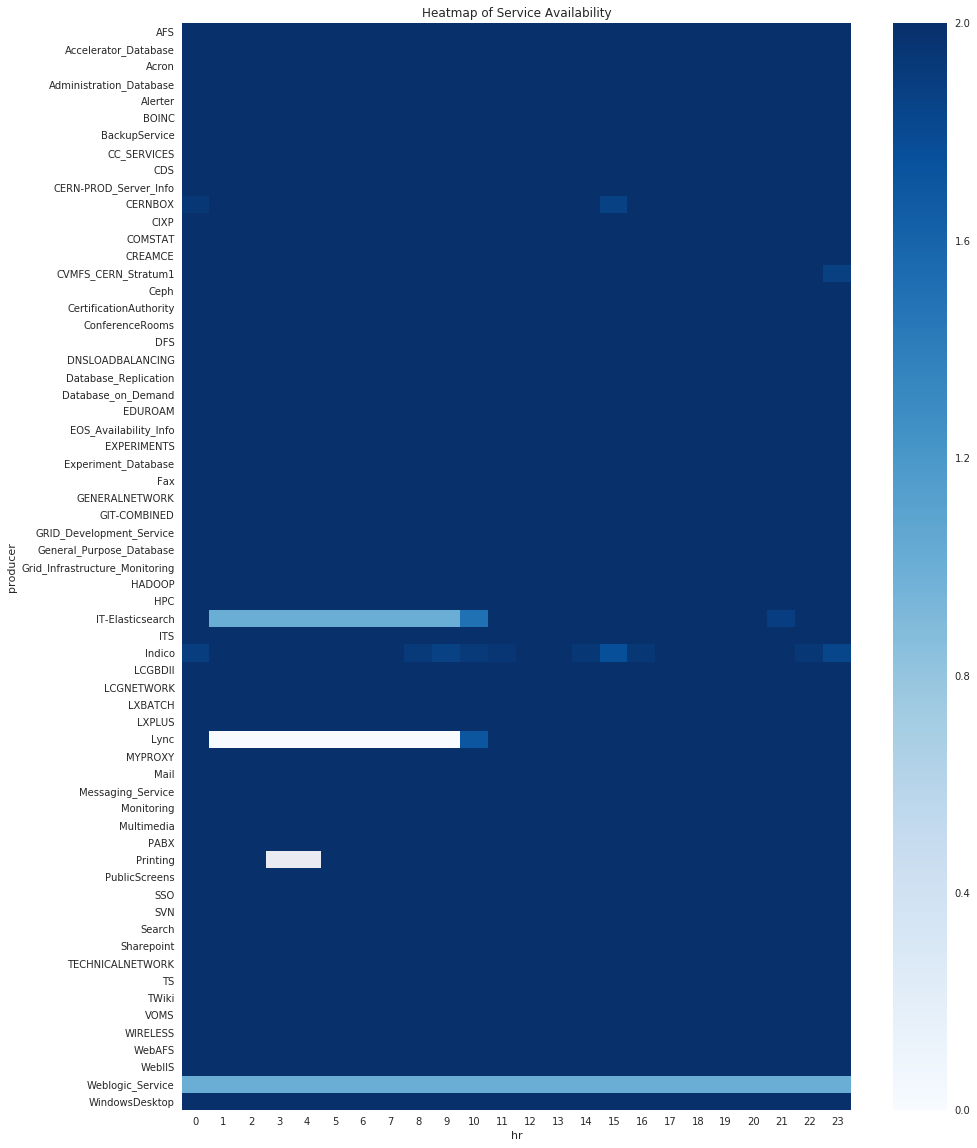

In [8]:
# heatmap of service availability
plt.figure(figsize=(15, 20))
ax = sns.heatmap(sls_pandas.pivot(index='producer', columns='hr', values='avg'), cmap="Blues")
ax.set_title("Heatmap of Service Availability")